# MyBinder Analytics Data Analysis

This notebook analyzes MyBinder launch data from the automated releases at the following URL:

[github.com/jupyterhub/binder-data/releases/tag/latest](https://github.com/jupyterhub/binder-data/releases/tag/latest)


In [26]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [27]:
def load_binder_data(
    url="https://github.com/jupyterhub/binder-data/releases/download/latest/launches.parquet",
):
    """
    Load MyBinder analytics data from GitHub release.

    Args:
        url: URL to the parquet file in GitHub releases

    Returns:
        DataFrame with binder launch data
    """
    print(f"Loading data from: {url}")

    try:
        df = pd.read_parquet(url)
        print(f"✓ Loaded {len(df):,} records")
        print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        df["timestamp"] = pd.to_datetime(df["timestamp"])    
        return df
    except Exception as e:
        print(f"✗ Failed to load data: {e}")
        raise  # Re-raise the exception to fail the notebook"

In [ ]:
# Load the data
df = load_binder_data()

## Launches Over Time by Source

Weekly trends of Binder launches grouped by the BinderHub that launched them.

In [28]:
def plot_launches_by_source_over_time(df):
    """
    Create interactive stacked area chart showing number of launches over time by week for each source.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "origin" not in df.columns:
        print("Missing required columns for time series analysis")
        return

    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    df_filtered = df[df["timestamp"] < latest_week_start]
    
    # Resample by week and count launches by origin
    df_weekly = (
        df_filtered.set_index("timestamp").groupby("origin").resample("W", include_groups=False).size().reset_index()
    )
    df_weekly.columns = ["origin", "week", "launches"]

    # Get top sources for better visualization
    top_sources = df_filtered["origin"].value_counts().head(8).index
    df_weekly_top = df_weekly[df_weekly["origin"].isin(top_sources)]

    fig = px.area(
        df_weekly_top, 
        x="week", 
        y="launches", 
        color="origin",
        title="MyBinder Launches Over Time by Source (Weekly - Stacked)",
        labels={"week": "Date", "launches": "Number of Launches", "origin": "Source"}
    )
    
    fig.update_layout(
        height=600,
        hovermode="x unified",
        legend=dict(orientation="h", yanchor="top", y=-0.1, xanchor="center", x=0.5)
    )
    
    fig.show()

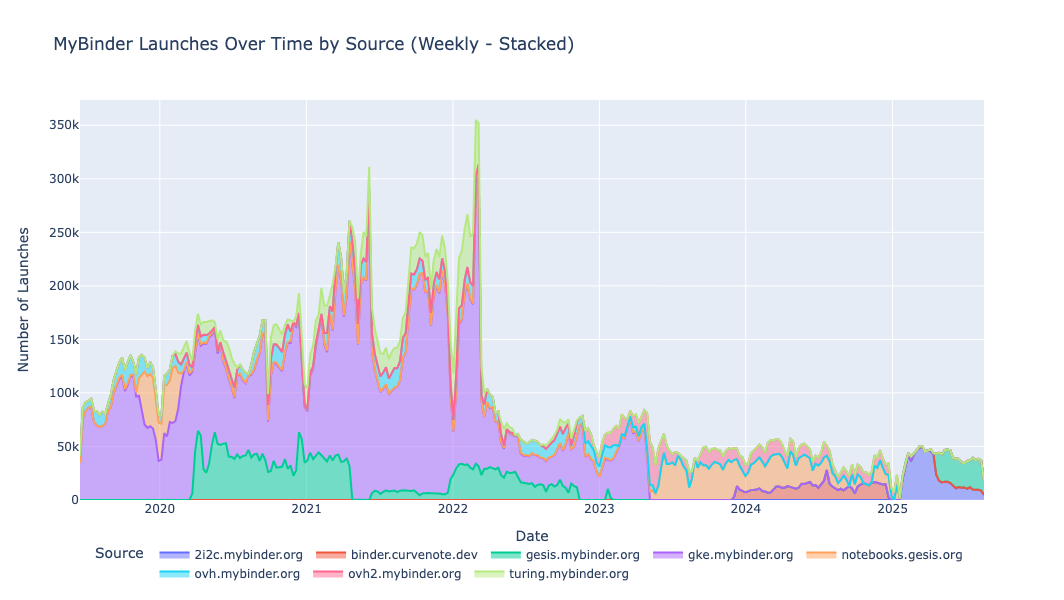

In [29]:
plot_launches_by_source_over_time(df)

## Top 25 Repositories (Last 90 Days)

The most popular repositories launched on MyBinder in the last 90 days.

In [30]:
def plot_top_repositories_last_90_days(df):
    """
    Create interactive horizontal bar chart of launches in the last 90 days for top 25 repositories.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "spec" not in df.columns:
        print("Missing required columns for repository analysis")
        return

    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    
    # Filter to last 90 days (excluding latest week)
    cutoff_date = latest_week_start - timedelta(days=90)
    df_recent = df[(df["timestamp"] >= cutoff_date) & (df["timestamp"] < latest_week_start)]
    
    # Pull only the repo so we aren't separating by the ref
    def remove_ref(s):
        parts = s.split("/")
        # Assume it is org/repo/ref
        if len(parts) == 3:
            return "/".join(parts[:2])
        # Assume it's something else
        else:
            return s
            
    df_recent["repo"] = df_recent["spec"].map(remove_ref)

    # Count launches by repository (spec)
    repo_counts = df_recent["repo"].value_counts().head(50)
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'repository': repo_counts.index,
        'launches': repo_counts.values
    })
    
    fig = px.bar(
        plot_df,
        x="launches",
        y="repository",
        orientation="h",
        title="Top 25 Repositories by Launches (Last 90 Days, excluding latest week)",
        labels={"launches": "Number of Launches", "repository": "Repository"},
        text="launches"
    )
    
    fig.update_layout(
        height=1600,
        yaxis={'categoryorder': 'total ascending'}
    )
    
    fig.update_traces(textposition='outside')
    
    fig.show()

/var/folders/0b/q7yt_htd6k58tpxzwmxdv5q00000gn/T/ipykernel_62467/2466142934.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



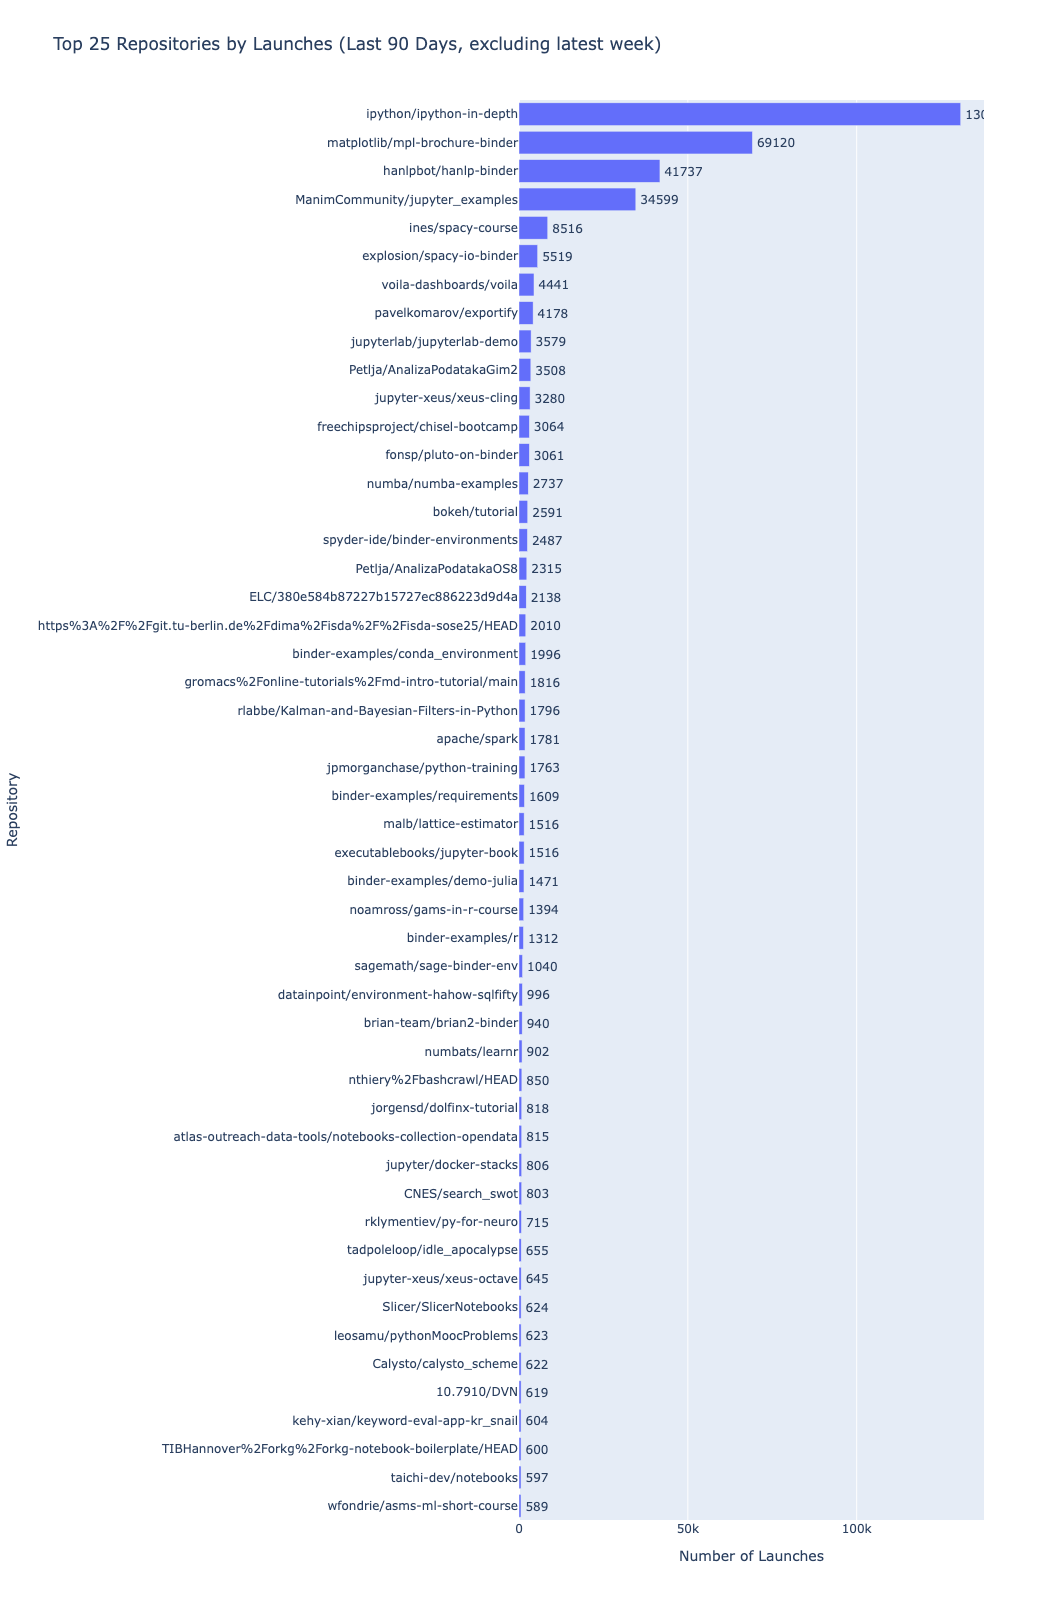

In [31]:
plot_top_repositories_last_90_days(df)

## Provider Distribution (Last 90 Days)

Distribution of launches by git provider (GitHub, GitLab, etc.) in the last 90 days.

In [32]:
def plot_provider_distribution_last_90_days(df):
    """
    Create bar chart showing distribution of launches by provider in the last 90 days.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "provider" not in df.columns:
        print("Missing required columns for provider analysis")
        return

    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    
    # Filter to last 90 days (excluding latest week)
    cutoff_date = latest_week_start - timedelta(days=90)
    df_recent = df[(df["timestamp"] >= cutoff_date) & (df["timestamp"] < latest_week_start)]

    # Count launches by provider
    provider_counts = df_recent["provider"].value_counts()
    
    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'provider': provider_counts.index,
        'launches': provider_counts.values
    })
    
    fig = px.bar(
        plot_df,
        x="provider",
        y="launches",
        title="MyBinder Launches by Provider (Last 90 Days, excluding latest week)",
        labels={"launches": "Number of Launches", "provider": "Provider"},
        text="launches"
    )
    
    fig.update_layout(
        height=600,
        xaxis={'categoryorder': 'total descending'}
    )
    
    fig.update_traces(textposition='outside')
    
    fig.show()

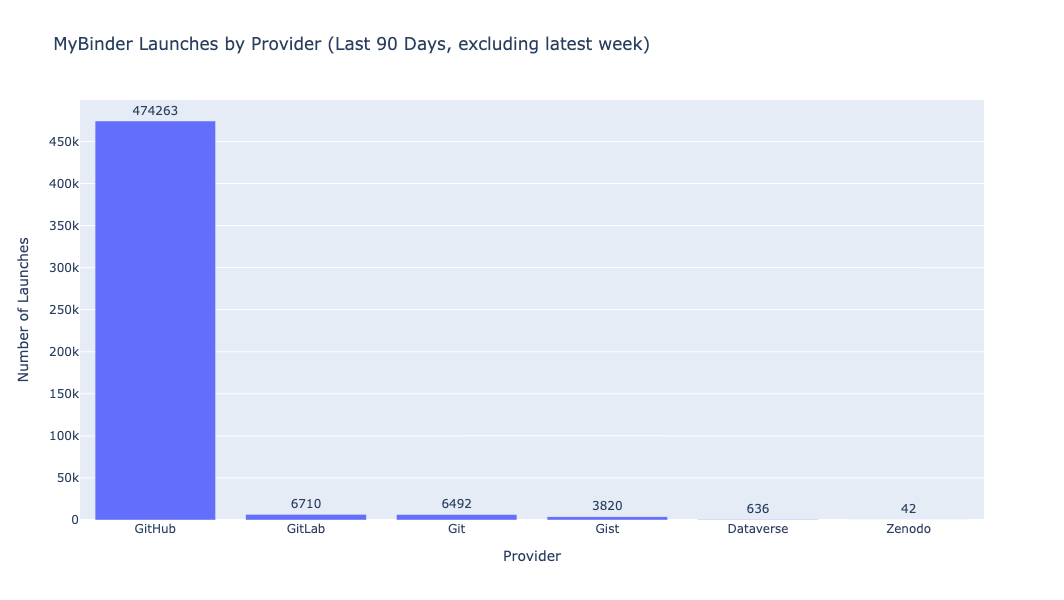

In [33]:
plot_provider_distribution_last_90_days(df)

In [34]:
def create_monthly_launches_table(df):
    """
    Create a table showing monthly launches by provider for the last 12 months.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "provider" not in df.columns:
        print("Missing required columns for monthly analysis")
        return
    
    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    
    # Filter to last 12 months (excluding latest week)
    cutoff_date = latest_week_start - timedelta(days=365)
    df_filtered = df[(df["timestamp"] >= cutoff_date) & (df["timestamp"] < latest_week_start)]
    
    # Create month-year column
    df_filtered = df_filtered.copy()
    df_filtered["month_year"] = df_filtered["timestamp"].dt.to_period("M")
    
    # Group by month and provider, count launches
    monthly_provider_counts = (
        df_filtered.groupby(["month_year", "provider"])
        .size()
        .reset_index(name="launches")
    )
    
    # Pivot to get providers as columns
    pivot_table = monthly_provider_counts.pivot(
        index="month_year", columns="provider", values="launches"
    ).fillna(0).astype(int)
    
    # Add total column
    pivot_table["Total"] = pivot_table.sum(axis=1)
    
    # Sort by month (most recent first)
    pivot_table = pivot_table.sort_index(ascending=False)
    
    # Convert index to string for better display
    pivot_table.index = pivot_table.index.astype(str)
    
    return pivot_table

In [40]:
monthly_table = create_monthly_launches_table(df)
monthly_table.style.set_caption("Monthly launches by repository provider.")

/var/folders/0b/q7yt_htd6k58tpxzwmxdv5q00000gn/T/ipykernel_62467/2561500563.py:19: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



provider,CKAN,Dataverse,Gist,Git,GitHub,GitLab,Zenodo,Total
month_year,,,,,,,,
2025-08,0,94,197,412,66517,747,0,67967
2025-07,0,183,532,2680,164851,2187,19,170452
2025-06,0,263,2770,2533,148275,2517,15,156373
2025-05,0,202,595,1707,188741,3077,12,194334
2025-04,0,249,787,1358,187716,4455,12,194577
2025-03,1,248,2260,2137,201730,3463,18,209857
2025-02,0,157,1217,2239,166815,2254,13,172695
2025-01,1,63,532,540,77871,1223,1,80231
2024-12,0,43,533,952,120874,1471,27,123900


## Monthly Launches by Provider (Last 12 Months)

Monthly breakdown of launches by provider with totals for the last 12 months.

In [41]:
def create_monthly_launches_table_by_origin(df):
    """
    Create a table showing monthly launches by BinderHub origin for the last 12 months.
    Excludes the latest week of data which may be incomplete.
    """
    if df.empty or "timestamp" not in df.columns or "origin" not in df.columns:
        print("Missing required columns for monthly origin analysis")
        return
    
    # Exclude the latest week of data (may be incomplete)
    latest_week_start = df["timestamp"].max() - timedelta(days=7)
    
    # Filter to last 12 months (excluding latest week)
    cutoff_date = latest_week_start - timedelta(days=365)
    df_filtered = df[(df["timestamp"] >= cutoff_date) & (df["timestamp"] < latest_week_start)]
    
    # Create month-year column
    df_filtered = df_filtered.copy()
    df_filtered["month_year"] = df_filtered["timestamp"].dt.to_period("M")
    
    # Group by month and origin, count launches
    monthly_origin_counts = (
        df_filtered.groupby(["month_year", "origin"])
        .size()
        .reset_index(name="launches")
    )
    
    # Pivot to get origins as columns
    pivot_table = monthly_origin_counts.pivot(
        index="month_year", columns="origin", values="launches"
    ).fillna(0).astype(int)
    
    # Add total column
    pivot_table["Total"] = pivot_table.sum(axis=1)
    
    # Sort by month (most recent first)
    pivot_table = pivot_table.sort_index(ascending=False)
    
    # Convert index to string for better display
    pivot_table.index = pivot_table.index.astype(str)
    
    return pivot_table

In [45]:
monthly_origin_table = create_monthly_launches_table_by_origin(df)
monthly_origin_table.style.set_caption("Monthly launches by BinderHub provider.")

/var/folders/0b/q7yt_htd6k58tpxzwmxdv5q00000gn/T/ipykernel_62467/608531760.py:19: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



origin,2i2c-bare.mybinder.org,2i2c.mybinder.org,binder.curvenote.dev,gesis.mybinder.org,notebooks-test.gesis.org,notebooks.gesis.org,ovh.mybinder.org,ovh2.mybinder.org,Total
month_year,,,,,,,,,
2025-08,0,16697,0,51270,0,0,0,0,67967
2025-07,0,46461,0,123991,0,0,0,0,170452
2025-06,0,49386,0,106987,0,0,0,0,156373
2025-05,12,68608,0,125714,0,0,0,0,194334
2025-04,16,131756,0,60149,0,2656,0,0,194577
2025-03,36,207370,0,0,0,2451,0,0,209857
2025-02,922,165014,0,0,0,6759,0,0,172695
2025-01,589,44664,0,0,0,20300,23,14655,80231
2024-12,0,0,33495,0,55,50605,226,39519,123900
